In [1]:
import os
from pathlib import Path

# Print the current working directory
starting_path = os.getcwd()

# Change directory to sleap-roots
if os.path.basename(os.getcwd()) == "sleap-roots":
    pass
else:
    os.chdir("..")
    
current_path = os.getcwd()

print(f"Starting directory: {starting_path}")
print(f"Current directory: {current_path}")

Starting directory: /Users/andrewoconnor/Projects/sleap-roots/notebooks
Current directory: /Users/andrewoconnor/Projects/sleap-roots


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import seaborn as sns

# Import the sleap_roots package
import sleap_roots as sr

# Use the following notation to import individual functions from the sleap_roots package
from sleap_roots.points import get_all_pts_array, filter_primary_roots_with_unexpected_count
from sleap_roots.convhull import get_convhull, get_chull_area, get_chull_perimeter
from sleap_roots.lengths import get_root_lengths, get_curve_index
from sleap_roots.bases import get_bases, get_base_tip_dist
from sleap_roots.tips import get_tips
from sleap_roots.series import Series
from sleap_roots.trait_pipelines import MultiplePrimaryRootPipeline

In [3]:
# Print sleap_roots version
print(sr.__version__)

0.1.3


---

The `MultiplePrimaryRootPipeline` was constructed for any experiment type that has multiple plants on a single image or frame of a video. The plants must all have a primary root.

This pipeline calculates the all traits related to the primary roots for each plant.

The pipeline runs on the `Series` object, which should contain sleap predictions.

### Example: Multiple Dicots (`multiple_arabidopsis_11do`)

In [4]:
# Change these variables for your own data
csv_path = "tests/data/multiple_arabidopsis_11do/merged_proofread_samples_03122024.csv" # For sample information (count, group, qc)
folder_path = "tests/data/multiple_arabidopsis_11do" # Location of h5 files and predictions

# Find all slp paths as a list
all_slps = sr.find_all_slp_paths(folder_path)
all_slps

['tests/data/multiple_arabidopsis_11do/6039_1.lateral.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/9535_1.primary.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/6039_1.primary.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/9535_1.lateral.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/997_1.lateral.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/7327_2.primary.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/7327_2.lateral.predictions.slp',
 'tests/data/multiple_arabidopsis_11do/997_1.primary.predictions.slp']

In [5]:
# Load all series as a list. Since h5 files are available in the folder, specify the h5s parameter as True
multiple_arabidopsis_all_series = sr.load_series_from_slps(slp_paths=all_slps,
                                                           h5s=True,
                                                           csv_path=csv_path)
multiple_arabidopsis_all_series

[Series(series_name='6039_1', h5_path='tests/data/multiple_arabidopsis_11do/6039_1.h5', primary_path='tests/data/multiple_arabidopsis_11do/6039_1.primary.predictions.slp', lateral_path='tests/data/multiple_arabidopsis_11do/6039_1.lateral.predictions.slp', crown_path=None, primary_labels=Labels(labeled_frames=67, videos=1, skeletons=1, tracks=0, suggestions=0), lateral_labels=Labels(labeled_frames=68, videos=1, skeletons=1, tracks=0, suggestions=0), crown_labels=None, video=Video(filename="tests/data/multiple_arabidopsis_11do/6039_1.h5", shape=(72, 1088, 2048, 1), dataset=vol, backend=HDF5Video), csv_path='tests/data/multiple_arabidopsis_11do/merged_proofread_samples_03122024.csv'),
 Series(series_name='997_1', h5_path='tests/data/multiple_arabidopsis_11do/997_1.h5', primary_path='tests/data/multiple_arabidopsis_11do/997_1.primary.predictions.slp', lateral_path='tests/data/multiple_arabidopsis_11do/997_1.lateral.predictions.slp', crown_path=None, primary_labels=Labels(labeled_frames=72,

In [6]:
# Print basic information about each series.
print(f"Number of series loaded: {len(multiple_arabidopsis_all_series)}\n")

for series in multiple_arabidopsis_all_series:
    print(f"Series name: {series.series_name}")
    print(f"Number of frames in video: {len(series)}")
    print(f"Expected plant count: {series.expected_count}") # Number of plants in a frame
    print(f"QC Fail Flag: {series.qc_fail}\n") # 0 = Passed QC, 1 = Failed QC

Number of series loaded: 4

Series name: 6039_1
Number of frames in video: 72
Expected plant count: 2
QC Fail Flag: 1

Series name: 997_1
Number of frames in video: 72
Expected plant count: 3
QC Fail Flag: 0

Series name: 9535_1
Number of frames in video: 72
Expected plant count: 3
QC Fail Flag: 0

Series name: 7327_2
Number of frames in video: 72
Expected plant count: 3
QC Fail Flag: 0



### Examining CSV path

`csv_path` is primarily used for pipelines that have multiple plants per image, where the number of plants is predetermined by the researcher.

If it is known that 3 plants are expected to be in a single image but 5 primary root instances are obtained after prediction, then we can easily adjust for this by excluding the frame from the analysis.

From the multiple arabidopsis series loaded in the previous cells, `series_name` corresponds to `plant_qr_code`. It uses the genotype as the prefix and the replicate as the suffix.

In [7]:
metadata = pd.read_csv(csv_path)
metadata.head()

,plant_qr_code,genotype,replicate,path,qc_cylinder,qc_code,number_of_plants_cylinder,primary_root_proofread,lateral_root_proofread,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Instructions
0,1002_1,1002,1,h5s_predictions\ES\1002_1.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5830_1,5830,1,h5s_predictions\ES\5830_1.h5,0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5830_2,5830,2,h5s_predictions\ES\5830_2.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5867_1,5867,1,h5s_predictions\ES\5867_1.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5867_2,5867,2,h5s_predictions\ES\5867_2.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Extract out sample metadata that are present in the data folder
arabidopsis_genotypes = ["6039_1", "7327_2", "997_1", "9535_1"]
relevant_metadata = metadata[metadata["plant_qr_code"].isin(arabidopsis_genotypes)]
relevant_metadata

,plant_qr_code,genotype,replicate,path,qc_cylinder,qc_code,number_of_plants_cylinder,primary_root_proofread,lateral_root_proofread,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Instructions
16,6039_1,6039,1,h5s_predictions\ES\6039_1.h5,1,NaN,2,1.0,1.0,NaN,NaN,NaN,NaN,NaN
63,7327_2,7327,2,h5s_predictions\ES\7327_2.h5,0,NaN,3,1.0,1.0,NaN,NaN,NaN,NaN,NaN
144,9535_1,9535,1,h5s_predictions\ES\9535_1.h5,0,NaN,3,1.0,1.0,NaN,NaN,NaN,NaN,NaN
348,997_1,997,1,h5s_predictions\ES\997_1.h5,0,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating MultiplePrimaryRoot traits for Series `7327_2`
- To demonstrate pipeline usage, the initial traits are calculated for this sample.
- From the metadata, we can expect that this sample should have 3 plants per frame.

In [9]:
series_7327 = [series for series in multiple_arabidopsis_all_series if series.series_name == "7327_2"][0]
print(series_7327)

Series(series_name='7327_2', h5_path='tests/data/multiple_arabidopsis_11do/7327_2.h5', primary_path='tests/data/multiple_arabidopsis_11do/7327_2.primary.predictions.slp', lateral_path='tests/data/multiple_arabidopsis_11do/7327_2.lateral.predictions.slp', crown_path=None, primary_labels=Labels(labeled_frames=43, videos=1, skeletons=1, tracks=0, suggestions=0), lateral_labels=Labels(labeled_frames=31, videos=1, skeletons=1, tracks=0, suggestions=0), crown_labels=None, video=Video(filename="tests/data/multiple_arabidopsis_11do/7327_2.h5", shape=(72, 1088, 2048, 1), dataset=vol, backend=HDF5Video), csv_path='tests/data/multiple_arabidopsis_11do/merged_proofread_samples_03122024.csv')


Number of frames: 72


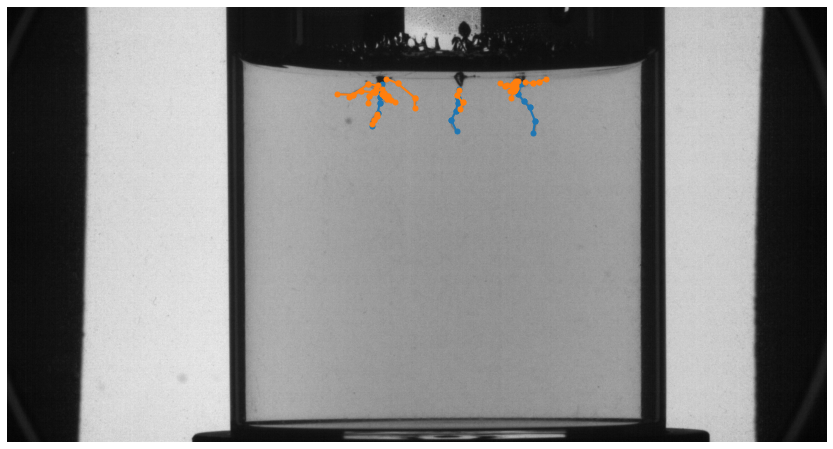

In [10]:
print(f"Number of frames: {len(series_7327)}")

# Plot the first frame
series_7327.plot(0, scale=0.4)

In [11]:
# Calculate initial traits.
frame_idx = 0
primary_points = series_7327.get_primary_points(frame_idx)
filtered_primary_pts_with_expected_ct = filter_primary_roots_with_unexpected_count(primary_points, series.expected_count)
filtered_primary_pts_with_expected_ct

array([[[1130.2388916 ,  205.91249084],
        [1126.3067158 ,  228.31256418],
        [1125.40202927,  241.14234532],
        [1121.43865279,  260.32125443],
        [1109.61537098,  283.00233494],
        [1122.97548247,  311.07535013]],

       [[ 936.60193647,  193.03896547],
        [ 934.24128437,  207.35588221],
        [ 930.51435026,  226.5629477 ],
        [ 930.96718895,  239.38204268],
        [ 925.48137498,  265.3652647 ],
        [ 912.58167434,  298.43848102]],

       [[1282.9359752 ,  193.02279961],
        [1277.21320909,  217.65921642],
        [1290.49814526,  235.99385861],
        [1305.65697036,  251.74212966],
        [1318.868075  ,  285.68266616],
        [1314.47108139,  314.53957278]]])

In [12]:
# Instantiate the MultiplePrimaryRootPipeline
pipeline = MultiplePrimaryRootPipeline()

# The output of this pipeline can be saved as a json or csv file by changing the relevant parameters to True
computed_traits = pipeline.compute_multiple_primary_roots_traits(series_7327, write_csv=False, write_json=False)
computed_traits

{'series': '7327_2',
 'group': '7327',
 'qc_fail': np.int64(0),
 'traits': {'primary_length': array([111.85610604, 108.95850619, 135.4037194 , 145.71073683,
         100.58056182, 122.17536555, 105.35141758, 144.56551811,
         123.41153321, 147.68763174, 105.3849969 , 120.67167256,
         144.34003744, 103.39767171, 125.13979023, 144.64596382,
          98.27477786, 120.62970447,  87.17159742, 117.81196068,
         141.5503117 ,  89.82460292, 124.61280515, 149.54257516,
         144.84216239,  99.9648107 , 123.20915569, 141.76189573,
         102.90495568, 119.92058599, 118.27488451, 146.70845867,
          99.80282475, 119.7042366 , 145.83065935, 100.19843038,
          99.20681033, 121.20885367, 142.22000951, 108.21529327,
         117.12850974, 139.47968509, 134.13051424, 113.93681379,
         107.09680807, 106.37633572, 113.00220996, 129.87411311,
         102.10768335, 117.01305415, 128.8050353 , 114.96456358,
          99.42099713, 133.51697798, 112.27169347, 131.9122834 

In [13]:
# Compute traits over multiple samples, grouping by genotype
# Note that samples which fail QC are not included
computed_traits_per_group = pipeline.compute_multiple_primary_roots_traits_for_groups(multiple_arabidopsis_all_series)
computed_traits_per_group

Skipping series '6039_1' due to qc_fail flag.
Processing series '997_1'
Finished processing group '997'
Processing series '9535_1'
Finished processing group '9535'
Processing series '7327_2'
Finished processing group '7327'


[{'group': '997',
  'series': ['997_1'],
  'traits': {'primary_length': array([594.56973846, 732.02597957, 341.91012867, 515.09416986,
          635.46755732, 214.06269166, 599.83450713, 828.50412475,
          625.82692794, 600.35936588, 797.47082403, 723.44393655,
          310.1346349 , 800.17441713, 834.72906105, 165.66602119,
          792.65987859, 813.7623385 , 840.03448816, 795.7262212 ,
          100.01057311, 377.0493461 , 806.51450241, 367.43773268,
          801.56660533, 747.22543197, 198.67017261, 342.2029046 ,
          806.79421753, 352.36605176, 601.0224787 , 128.36793515,
          665.59548068,  54.61578871, 810.19394979, 534.68017454,
           63.9488949 , 527.47379991, 659.14043517, 386.77701387,
          812.71179637, 804.88579224, 813.0027196 , 815.20538631,
          203.99828617, 811.46467032, 815.13470981,  71.4056945 ,
          813.56943858, 589.49257527, 775.82430537, 261.40459945,
          659.21371636, 541.56607149, 150.09948209, 650.99558032,
       

In [14]:
# Compute batch traits over multiple samples
batch_computed_traits = pipeline.compute_batch_multiple_primary_roots_traits(multiple_arabidopsis_all_series)
batch_computed_traits

Processing series '6039_1'
Processing series '997_1'
Processing series '9535_1'
Processing series '7327_2'


,series_name,primary_length_min,primary_length_max,primary_length_mean,primary_length_median,primary_length_std,primary_length_p5,primary_length_p25,primary_length_p75,primary_length_p95,...,primary_base_tip_dist_p95,curve_index_min,curve_index_max,curve_index_mean,curve_index_median,curve_index_std,curve_index_p5,curve_index_p25,curve_index_p75,curve_index_p95
0,6039_1,74.343080,115.579339,91.517506,86.855562,11.378560,78.059322,81.440237,103.285035,109.097974,...,100.482057,0.006797,0.210484,0.076197,0.073527,0.048984,0.011785,0.034093,0.096508,0.179773
1,997_1,54.615789,840.034488,564.141947,635.467557,249.653896,102.846309,347.284478,803.226199,815.561690,...,830.894756,0.000776,0.011918,0.004782,0.003869,0.003165,0.000971,0.002268,0.007226,0.010499
2,9535_1,122.032826,233.037278,186.711810,196.228885,31.633507,140.553204,148.607301,211.195199,228.367724,...,221.868373,0.003453,0.089403,0.043774,0.045032,0.019952,0.012682,0.028032,0.058621,0.079298
3,7327_2,87.171597,149.542575,119.379985,117.128510,15.192294,99.867619,106.627546,130.413280,145.361402,...,137.610203,0.002016,0.133045,0.048613,0.040756,0.030923,0.010048,0.022974,0.075188,0.102796


In [15]:
# Compute batch traits over multiple samples, grouping by genotype
# Note that samples which fail QC are not included
group_batch_computed_traits = pipeline.compute_batch_multiple_primary_roots_traits_for_groups(multiple_arabidopsis_all_series)
group_batch_computed_traits

Skipping series '6039_1' due to qc_fail flag.
Processing series '997_1'
Finished processing group '997'
Processing series '9535_1'
Finished processing group '9535'
Processing series '7327_2'
Finished processing group '7327'


,genotype,primary_length_min,primary_length_max,primary_length_mean,primary_length_median,primary_length_std,primary_length_p5,primary_length_p25,primary_length_p75,primary_length_p95,...,primary_base_tip_dist_p95,curve_index_min,curve_index_max,curve_index_mean,curve_index_median,curve_index_std,curve_index_p5,curve_index_p25,curve_index_p75,curve_index_p95
0,997,54.615789,840.034488,564.141947,635.467557,249.653896,102.846309,347.284478,803.226199,815.561690,...,830.894756,0.000776,0.011918,0.004782,0.003869,0.003165,0.000971,0.002268,0.007226,0.010499
1,9535,122.032826,233.037278,186.711810,196.228885,31.633507,140.553204,148.607301,211.195199,228.367724,...,221.868373,0.003453,0.089403,0.043774,0.045032,0.019952,0.012682,0.028032,0.058621,0.079298
2,7327,87.171597,149.542575,119.379985,117.128510,15.192294,99.867619,106.627546,130.413280,145.361402,...,137.610203,0.002016,0.133045,0.048613,0.040756,0.030923,0.010048,0.022974,0.075188,0.102796
